In [1]:
import sys
sys.path.insert(0,'..')
sys.path.insert(0,'../../WobbleSim')
import simulacra.dataset
import astropy
import astropy.units as u 
import astropy.coordinates as coord
import astropy.time as at
import astropy.constants as const
import numpy as np
import scipy.optimize

import jabble.dataset
import jabble.loss
import jabble.model

import matplotlib.pyplot as plt

<h1>42 - make dumb data</h1>
redo the simulated data in the simplest way possible. just star no tellurics maybe gaussian noise

In [2]:
import os
import datetime
today = datetime.date.today()
out_dir = os.path.join('..','out',today.strftime("%d-%m-%y"))
os.makedirs(out_dir,exist_ok=True)

In [3]:
def gaussian(x,mu,sigma):
    return np.exp(-(x - mu)**2/(2 * sigma**2)) #/ (2 * sigma * np.sqrt(2 * np.pi))

In [4]:
resolution = 120_000
snr        = 100
epoches    = 20

dx = jabble.dataset.delta_x(2*resolution)
x_grid    = np.arange(np.log(4538),np.log(4547),step=dx)
wave_grid = np.exp(x_grid) * u.Angstrom

guess_vel  = np.linspace(-60,60,epoches) * u.km/u.s
extra_vel  = np.linspace(-5,5,epoches)   * u.km/u.s
velocities = guess_vel + extra_vel
shifts     = jabble.dataset.shifts(velocities).value

# means = [np.log(4542)]
means = [np.log(4541),np.log(4542),np.log(4543),np.log(4544)]
flux = np.ones((epoches,*wave_grid.shape)) 
print(type(shifts),type(dx),type(x_grid))
for mean in means:
    flux -= 0.7 * gaussian(np.repeat((x_grid)[np.newaxis,:],epoches,axis=0),np.repeat((mean + shifts)[:,np.newaxis],wave_grid.shape[0],axis=1),dx)

# add noise
for j in range(flux.shape[0]):
    for k in range(flux.shape[1]):
        flux[j,k] -= np.random.normal(0.0,np.abs(flux[j,k]/snr))
ferr = flux/snr

<class 'numpy.ndarray'> <class 'numpy.float64'> <class 'numpy.ndarray'>


In [5]:
dataset = jabble.dataset.Dataset.from_flux(np.repeat((wave_grid)[np.newaxis,:],epoches,axis=0),flux,ferr,mask=np.ones(flux.shape))

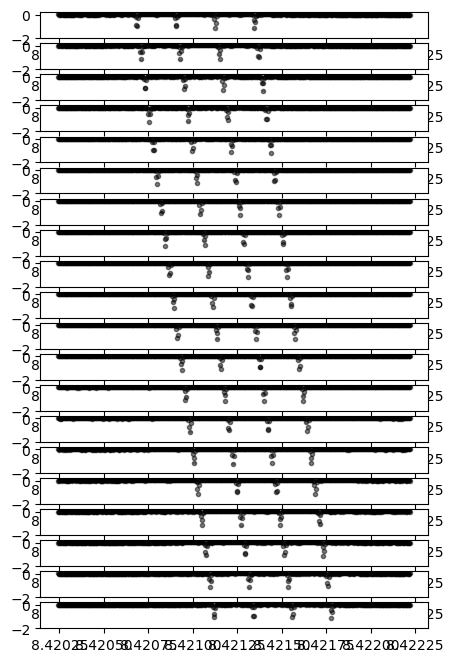

In [6]:
plt_inds = epoches
xpmin = np.log(4550)
xpmax = np.log(4560)
fig, axes = plt.subplots(plt_inds,figsize=(5,8))
for ele in range(plt_inds):
    axes[ele].errorbar(dataset.xs[ele,:],dataset.ys[ele,:],dataset.yerr[ele,:],fmt='.k',elinewidth=2.2,zorder=1,alpha=0.5,ms=6)
#     axes[ele].set_xlim(xpmin-shifts[ele],xpmax-shifts[ele])
    axes[ele].set_ylim(-2,0.2)
plt.show() 

In [7]:
type(dataset.xs), type(dataset.ys), type(dataset.mask), type(dataset.yivar)

(numpy.ndarray, numpy.ndarray, numpy.ndarray, numpy.ndarray)

In [8]:
loss = jabble.loss.ChiSquare()
init_vels   = guess_vel
init_shifts = jabble.dataset.shifts(init_vels)

In [9]:
x_grid.shape

(476,)

In [10]:
import jax

In [11]:
from collections import namedtuple

In [12]:
from jaxopt import GaussNewton
import jax.numpy as jnp

class MyModel(jabble.model.CompositeModel):
    def grad_descent(self,loss,data,verbose=False,options={},save_history=False,save_loss=False,*args):
        # Fits the Model
        self.save_history = save_history
        self.save_loss    = save_loss
        # if loss is None:
        #     loss_ind = np.arange(data.shape[0])

        func_grad = jax.value_and_grad(loss.loss_all, argnums=0)
        def val_gradient_function(p,*args):
            val, grad = func_grad(p,*args)
            self.func_evals.append(val)
            if verbose:
                print('\r[ Value: {:+3.2e} Grad: {:+3.2e} ]'.format(val,np.inner(grad,grad)))

            if self.save_history:
                self.history.append(np.array(p))

            if self.save_loss:
                initialize = loss(p,data,0,self)
                tmp        = np.zeros((data.ys.shape[0],*initialize.shape))
                tmp[0,...] = initialize
                for i in range(1,data.ys.shape[0]):
                    tmp[i,...] = loss(p,data,i,self)
                self.loss_history.append(tmp)

            return np.array(val,dtype='f8'),np.array(grad,dtype='f8')

        res = grad_descent(val_gradient_function, self.get_parameters(), data, self, options=options)
        self.results.append(res)
        self.unpack(res.x)
        return res
    
    def gaussnewton(self,data,verbose=False,save_history=False,save_loss=False,*args):
        # Fits the Model
        self.save_history = save_history
        self.save_loss    = save_loss
        # if loss is None:
        #     loss_ind = np.arange(data.shape[0])
        def chi_1(p):
            residual = jnp.zeros(data.xs.shape)
            for i in range(data.xs.shape[0]):
                
                residual = residual.at[i,:].set((data.ys[i,:] - self(p,data.xs[i,:],i)) * data.yivar[i,:])
            return residual
        
        
#         func_grad = jax.value_and_grad(chi_1, argnums=0)
#         def val_gradient_function(p,*args):
#             val, grad = func_grad(p,*args)
#             self.func_evals.append(val)
#             if verbose:
#                 print('\r[ Value: {:+3.2e} Grad: {:+3.2e} ]'.format(val,np.inner(grad,grad)))

#             if self.save_history:
#                 self.history.append(np.array(p))

        gn = GaussNewton(residual_fun=chi_1)
        gn_sol = gn.run(self.get_parameters())
        
        self.results.append(gn_sol)
        self.unpack(gn_sol.params)
        return gn_sol
    
    def new_lbfgsb(self,loss,data,verbose=False,save_history=False,save_loss=False):
        # Fits the Model
#         self.save_history = save_history
#         self.save_loss    = save_loss
        # if loss is None:
        #     loss_ind = np.arange(data.shape[0])

        func_grad = jax.value_and_grad(loss.loss_all, argnums=0)
        def val_gradient_function(p,*args):
            val, grad = func_grad(p,*args)
            self.func_evals.append(val)
            if verbose:
                print('\r[ Value: {:+3.2e} Grad: {:+3.2e} ]'.format(val,np.inner(grad,grad)))

            if self.save_history:
                self.history.append(np.array(p))

            if self.save_loss:
                initialize = loss(p,data,0,self)
                tmp        = np.zeros((data.ys.shape[0],*initialize.shape))
                tmp[0,...] = initialize
                for i in range(1,data.ys.shape[0]):
                    tmp[i,...] = loss(p,data,i,self)
                self.loss_history.append(tmp)

            return np.array(val,dtype='f8'),np.array(grad,dtype='f8')

        x, f, d = scipy.optimize.fmin_l_bfgs_b(val_gradient_function, self.get_parameters(), None, (data, self))
        self.results.append(d)
        self.unpack(x)
        return d

In [13]:
dataset.xs.shape

(20, 476)

In [14]:
class MyShiftingModel(jabble.model.ShiftingModel):
    def grid_search(self,grid,loss,model,data,epoches=None):
        if epoches is None:
            epoches = slice(0,self.n)
        # put all submodels in fixed mode except the shiftingmodel
        # to be searched then take loss of each epoch
        # that we hand the loss a slice of the shift array
        # since at __call__ itll on take the shift_grid[i,j] element
        model.fix()
        # index is the index of the submodel to grid search this is redundant
        self.fit(epoches=epoches)
        if isinstance(model,jabble.model.ContainerModel):
            model.get_parameters()
        # this is called because this resets the parameters per model
        # array
        # I want to have this be done when a submodel is put into fix or fix mode
        loss_arr = np.empty(grid.shape)
        for i in range(grid.shape[0]):
            for j in range(grid.shape[1]):
                # print(shift_grid[:,j].shape)
                out = loss(grid[:,j],data,i,model)
#                 print(out.shape)
                loss_arr[i,j] = np.sum(out)
        return loss_arr

In [15]:
vel_padding = 100 * u.km/u.s
model_grid = jabble.model.create_x_grid(x_grid,vel_padding,2*resolution)#step=jabble.dataset.shifts(const.c.to(u.km/u.s)/resolution))
stellar_model = MyModel([MyShiftingModel(init_shifts),jabble.model.BSplineModel(model_grid,2)])

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


In [16]:
def grad_descent(val_grad,p,data,model,options):
    
    res = namedtuple('Results', ['x','jac'])
    iteration = 1
    grad = [1e99]
    
#     anneal = 1./np.e
    while np.inner(grad,grad) > options['condition']:
        val, grad = val_grad(p,data,model)
        delta_x   = grad*options['size']#*anneal**(iteration-1)
        print('\r[ Value: {:+3.2e} Grad: {:+3.2e} ]'.format(val,np.inner(grad,grad)))
        p         -= delta_x
        iteration += 1
        if options['maxiter'] < iteration:
            print('maxiter reached')
            break
        
    res.x = p
    res.jac = grad
    return res

In [17]:
# def train_cycle(model,dataset):
#     n_cycles = 3
#     for iii in range(n_cycles):
#         print('fitting round {} 1'.format(iii))
#         model.fix()
#         model.fit(1)
#         model.gaussnewton(dataset,verbose=True)
        
#         print('fitting round {} 2'.format(iii))
#         model.fix()
#         model.fit(0)
#         model.gaussnewton(dataset,verbose=True)
        
#         return model

In [18]:
def train_cycle(model,dataset,loss):
    n_cycles = 3
#     lbfgs_options = {"maxiter":15000,'maxls':256,'ftol':1e-100,'gtol':1e-100,'tol':1e-100,'eps':1e-100}
#     grad1_options  = {'maxiter': 512, 'size': 1e-7, 'condition': 1e3}
#     grad2_options  = {'maxiter': 512, 'size': 1e-18, 'condition': 1e3}

    for iii in range(n_cycles):
        # Fitting Round 1
        print('fitting round {} 0'.format(iii))
        model.fix()
        model.fit(1)
        res1 = model.new_lbfgsb(loss,dataset)
        print(res1['warnflag'],res1['nit'])
        
        # Fitting Round 3
        print('fitting round {} 1'.format(iii))
        model.fix()
        model.fit(0)
        res1 = model.new_lbfgsb(loss,dataset)
        print(res1['warnflag'],res1['nit'])
        
    return model

In [19]:
# def train_cycle(model,dataset,loss):
#     options = {"maxiter":15000,'maxls':256,'ftol':1e-60,'gtol':1e-35,'tol':1e-30,'eps':1e-60}
#     options_2 = {}
    
#     # Fitting Round 1
#     print('fitting round 1')
#     model.fix()
#     model.fit(1)
#     res1 = model.optimize(loss,dataset,options=options,verbose=False)
#     print(res1['message'],res1['nit'])
    
#     # Fitting Round 2
#     print('fitting round 2')
#     model.fix()
#     model.fit(0)
#     res2 = model.optimize(loss,dataset,options=options,verbose=False)
#     print(res2['message'],res2['nit'])
    
# #     # Fitting Round 3
# #     print('fitting round 3')
# #     model.fix()
# #     model.fit(1)
# #     res3 = model.optimize(loss,dataset,method='Newton-CG',options=options_2,verbose=False)
# #     print(res3['message'],res3['nit'])
    
#     # Fitting Round 4
# #     vel_grid   = np.linspace(-6,6,200) * u.km/u.s
# #     shift_grid = jabble.dataset.shifts(vel_grid)[None,:] * np.ones(epoches)[:,None]
# #     loss_array = model[0].grid_search(shift_grid,loss,model,dataset)
# #     x_min      = jabble.dataset.get_parabolic_min(loss_array,shift_grid)
# #     model[0].p = x_min
    
#     # Fitting Round 5
#     print('fitting round 5')
#     model.fix()
#     model.fit(0)
#     model.fit(1)
#     res5 = model.optimize(loss,dataset,options=options,verbose=True)
#     print(res5['message'],res5['nit'])
    
#     # Fitting Round 6
#     print('fitting round 6')
#     options = {'maxiter': 256, 'size': 1e-15, 'condition': 1e10}
#     model.fix()
#     model.fit(1)
#     res1 = model.grad_descent(loss,dataset,options=options,verbose=True)
    
#     print('fitting round 7')
#     model.fix()
# #     model.fit(0)
#     model.fit(1)
#     res5 = model.optimize(loss,dataset,options=options,verbose=True)
#     print(res5['message'],res5['nit'])
    
#     vel_grid   = np.linspace(-500,500,500) * u.m/u.s
#     shift_grid = jabble.dataset.shifts(vel_grid)[None,:] + model[0].p[:,None]
#     loss_array = model[0].grid_search(shift_grid,loss,model,dataset)
#     x_min      = jabble.dataset.get_parabolic_min(loss_array,shift_grid)
#     model[0].p = x_min
    
#     plt_epoch = 20
#     yax = 4
#     fig, axes = plt.subplots(yax,5,figsize=(12,10),sharex=False,sharey=True,facecolor=(1, 1, 1),dpi=200)
#     for j in range(plt_epoch):

#         axes[j%yax, j//yax].plot(shift_grid,\
#                              loss_array,\
#                              '.k',zorder=1,alpha=0.5,ms=6)

#     plt.savefig(os.path.join(out_dir,'42-gridsrch.png'),dpi=300,bbox_inches='tight')
#     plt.show()
    
#     # Fitting Round 8
#     print('fitting round 8')
#     options = {'maxiter': 512, 'size': 1e-16, 'condition': 1e1}
#     model.fix()
#     model.fit(1)
#     res1 = model.grad_descent(loss,dataset,options=options,verbose=True)
    
#     # Round 9
#     print('fitting round 9')
#     model.fix()
#     model.fit(0)
# #     model.fit(1)
#     res5 = model.optimize(loss,dataset,options=options,verbose=True)
#     print(res5['message'],res5['nit'])
    
    
#     print('fitting round 10')
#     options = {'maxiter': 512, 'size': 1e-16, 'condition': 1e1}
#     model.fix()
#     model.fit(1)
#     res1 = model.grad_descent(loss,dataset,options=options,verbose=True)
    
#     print('fitting round 11')
#     model.fix()
#     model.fit(0)
# #     model.fit(1)
#     res5 = model.optimize(loss,dataset,options=options,verbose=True)
#     print(res5['message'],res5['nit'])
    
#     print('fitting round 12')
#     options = {'maxiter': 512, 'size': 1e-13, 'condition': 1e1}
#     model.fix()
#     model.fit(1)
#     res1 = model.grad_descent(loss,dataset,options=options,verbose=True)
    
#     print('fitting round 13')
#     model.fix()
#     model.fit(0)
# #     model.fit(1)
#     res5 = model.optimize(loss,dataset,options=options,verbose=True)
#     print(res5['message'],res5['nit'])
#     return model

In [20]:
# def train_cycle(model,dataset,loss):
    
#     options = {'maxiter': 256, 'size': 1e-6, 'condition': 1e10}
#     model.fix()
#     model.fit(1)
#     res1 = model.grad_descent(loss,dataset,options=options,verbose=True)
    
#     options = {'maxiter': 100, 'size': 1e-25, 'condition': 1e10}
#     model.fix()
#     model.fit(0)
#     res2 = model.grad_descent(loss,dataset,options=options,verbose=True)
    
#     options = {'maxiter': 100, 'size': 1e-10, 'condition': 1e10}
#     model.fix()
#     model.fit(0)
#     model.fit(1)
#     res2 = model.grad_descent(loss,dataset,options=options,verbose=True)
#     return model

In [21]:
stellar_model = train_cycle(stellar_model,dataset,loss)

fitting round 0 0
0 14
fitting round 0 1
2 4
fitting round 1 0
0 32
fitting round 1 1
2 2
fitting round 2 0
0 25
fitting round 2 1
2 1


In [22]:
estimate_vel = jabble.dataset.velocities(stellar_model[0].p)
velocities.to(u.m/u.s), estimate_vel

(<Quantity [-65000.        , -58157.89473684, -51315.78947368,
            -44473.68421053, -37631.57894737, -30789.47368421,
            -23947.36842105, -17105.26315789, -10263.15789474,
             -3421.05263158,   3421.05263158,  10263.15789474,
             17105.26315789,  23947.36842105,  30789.47368421,
             37631.57894737,  44473.68421053,  51315.78947368,
             58157.89473684,  65000.        ] m / s>,
 <Quantity [-64937.87109341, -58191.04704799, -51313.12470187,
            -44524.73704357, -37604.40949286, -30813.14525259,
            -23891.59852639, -17069.07084053, -10201.27511918,
             -3441.81933315,   3423.20077671,  10349.74140863,
             17015.40726392,  23986.64728541,  30793.19413346,
             37571.67457819,  44474.69934168,  51302.99321711,
             58204.24597319,  64990.0913657 ] m / s>)

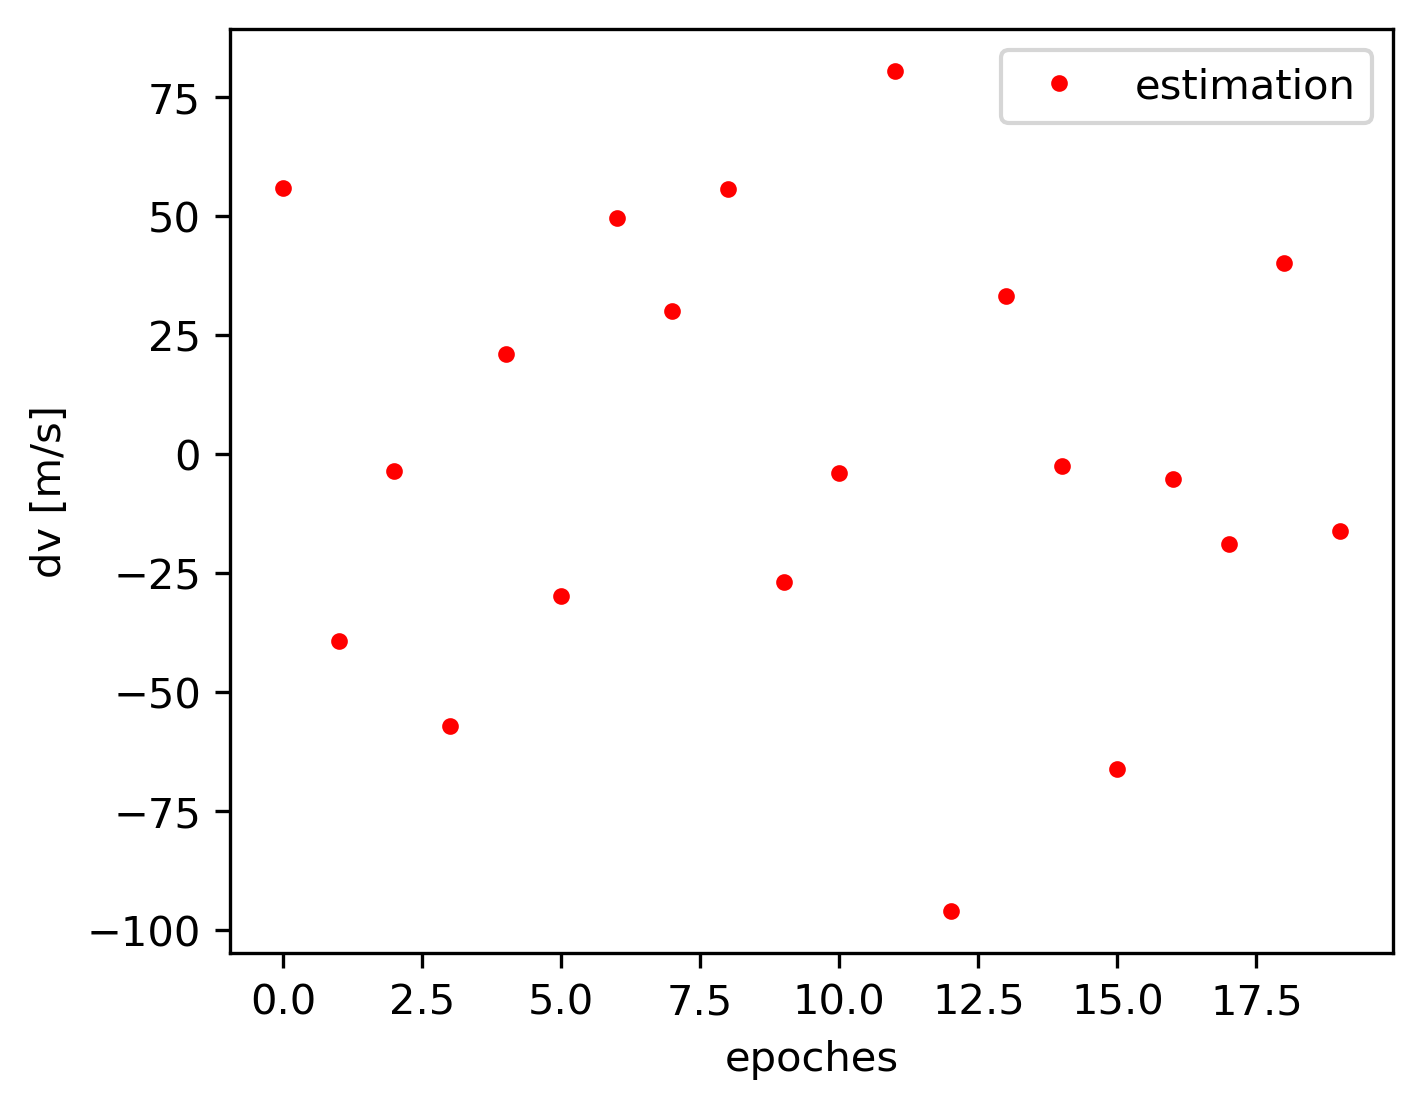

In [23]:
fig,ax = plt.subplots(1,figsize=(5,4),facecolor=(1,1,1),dpi=300)

epoch_range = np.arange(0,epoches,dtype=int)
# ax.plot(epoch_range,extra_vel.to(u.m/u.s).value,'.g',label='initialization')

dv = estimate_vel.to(u.m/u.s).value - estimate_vel.to(u.m/u.s).value.mean() - velocities.to(u.m/u.s).value
ax.plot(epoch_range,dv,'.r',label='estimation')

# ax.set_ylim(-5.5e3,5.5e3)
# for epoch in epoch_range:
#     constant = 1e-5
#     ax.arrow(epoch,dv[epoch],0.0,constant*stellar_model.results[-1].jac[epoch])

# twin_ax = ax.twinx()
# twin_ax.plot(stellar_model.results[-1]['jac'][:stellar_model[0].p.shape[0]],'om',alpha=0.3,label='gradient')
# twin_ax.set_ylim(-1e9,1e9)
ax.set_ylabel('dv [m/s]')
plt.xlabel('epoches')
ax.legend()
plt.savefig(os.path.join(out_dir,'42-dv.png'))
plt.show()

In [24]:
def norm_func(y,sigma):
    y_low = scipy.ndimage.gaussian_filter(y,sigma)
    return y_low/y

In [25]:
out_dir

'../out/10-07-23'

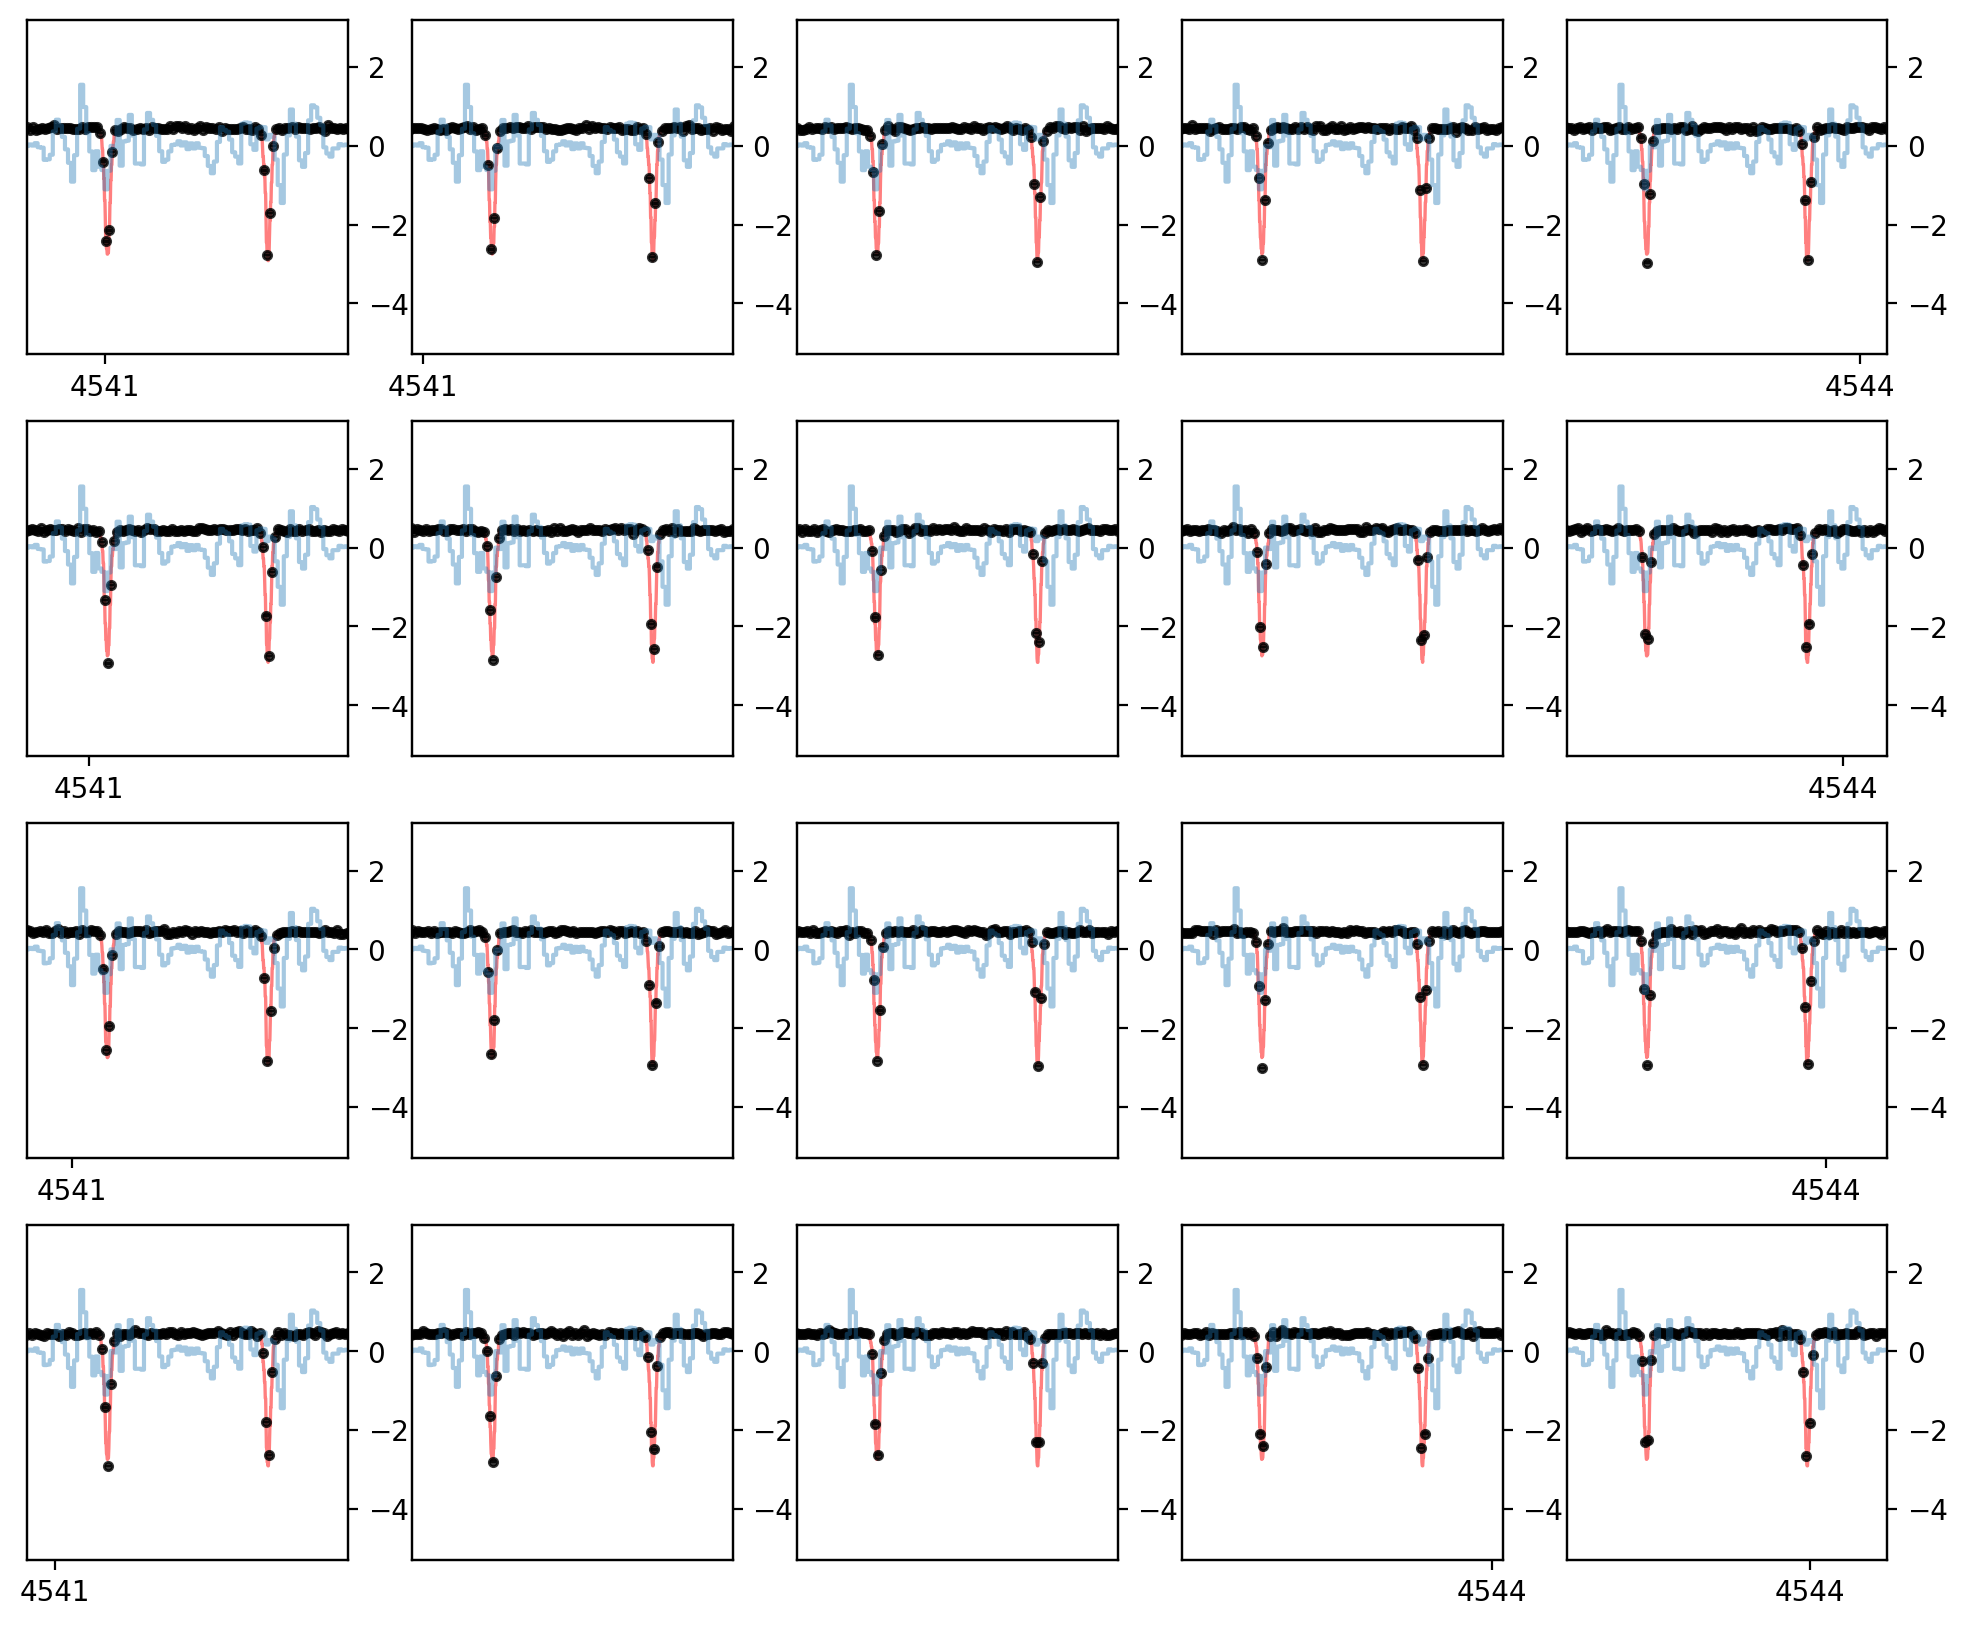

In [26]:
lmin = 4538
lmax = 4550
x_window = np.log(4550) - np.log(4549)
stellar_model.fix()

lrange = np.arange(lmin,lmax,3)
plt_unit = u.Angstrom
plt_epoch = 20
yax = 4
fig, axes = plt.subplots(yax,5,figsize=(12,10),sharex=False,sharey=True,facecolor=(1, 1, 1),dpi=200)
for j in range(plt_epoch):
    axes[j%yax, j//yax].errorbar(dataset.xs[j,:],dataset.ys[j,:],\
                             dataset.yerr[j,:],fmt='.k',\
                             elinewidth=2.2,zorder=3,alpha=0.8,ms=6)
#     axes[j%yax, j//yax].plot(stellar_model[1].xs+stellar_model[0].p[j],\
#                          stellar_model[1].p,\
#                          '.r',linestyle='solid',linewidth=1.2,zorder=1,alpha=0.5,ms=6)
    xplot = np.linspace(np.log(lmin),np.log(lmax),5000)
    axes[j%yax, j//yax].plot(xplot,stellar_model([],xplot,j),'-r',linewidth=1.2,zorder=1,alpha=0.5,ms=6)
    
    axes[j%yax, j//yax].set_ylim(-2,1)
    axes[j%yax, j//yax].set_yticks([])
    
    axes[j%yax, j//yax].set_xticks(np.log(lrange))
    axes[j%yax, j//yax].set_xticklabels(['{:2.0f}'.format(x) for x in lrange])
    axes[j%yax, j//yax].set_xlim(np.mean(means)-x_window+stellar_model[0].p[j],np.mean(means)+x_window+stellar_model[0].p[j])
    
    res_ax = axes[j%yax, j//yax].twinx()
#     res_ax.set_yticks([])
#     res_ax = axes[j%2,j//2].twinx()
#     residual = loss(stellar_model.get_parameters(),dataset,j,stellar_model)
#     res_ax.step(dataset.xs[j,:],residual,where='mid',alpha=0.3,label='residual')
    res_ax.step(stellar_model[1].xs+stellar_model[0].p[j],\
                stellar_model.results[-2]['grad'][:],\
                where='mid',alpha=0.4,label='residual',zorder=-1)

# stellar_model[0].p.shape[0]
#     res_ax.set_xlim(xpmin,xpmax)
#     res_ax.set_ylim(-2e4,1e5)
    
plt.savefig(os.path.join(out_dir,'42-allplots.png'),dpi=300,bbox_inches='tight')
plt.show()

In [27]:
for res in stellar_model.results:
    print(res)
#     print(res['hess_inv'])

{'grad': array([ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00, -1.65608251e+00,
       -8.46125317e+00,  3.20607491e+01, -1.17045336e+01, -2.72392869e+00,
        2.76271610e+01,  2.21092987e+01, -4.13269043e-01, -1.75217438e+00,
        3.63551331e+00, -1.00527220e+01, -5.93247175e+00,  9.11791992e+00,
        5.61784363e+00, -6.79167938e+00, -5.22603369e+00, -1.12335815e+01,
        3.18746948e+00, -5.10203552e+00,  1.24094238e+01, -5.48606873e-01,
        6.624359

In [28]:
print(res)

{'grad': array([ 1.94512614e+09, -4.16117862e+09,  2.32995098e+09, -3.01321779e+09,
       -1.28931277e+09, -2.46292173e+09, -1.31650317e+09, -2.00588736e+09,
       -1.21040928e+08, -8.91295360e+08,  8.66477248e+08, -1.06918592e+08,
        1.60260864e+09,  8.47355968e+08,  2.57586842e+09, -2.77424154e+09,
        2.65508582e+09, -2.41724774e+09,  3.57922406e+09, -1.44393984e+09]), 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 52, 'nit': 1, 'warnflag': 2}


In [29]:
# def train_cycle(model,dataset,loss):
#     options = {"maxiter":15000,'maxls':256,'ftol':1e-60,'gtol':1e-35,'tol':1e-30,'eps':1e-60}
#     options_2 = {}
    
#     # Fitting Round 1
#     print('fitting round 1')
#     model.fix()
#     model.fit(1)
#     res1 = model.optimize(loss,dataset,options=options,verbose=False)
#     print(res1['message'],res1['nit'])
    
#     # Fitting Round 2
#     print('fitting round 2')
#     model.fix()
#     model.fit(0)
#     res2 = model.optimize(loss,dataset,options=options,verbose=False)
#     print(res2['message'],res2['nit'])
    
#     # Fitting Round 3
#     print('fitting round 3')
#     model.fix()
#     model.fit(1)
#     res3 = model.optimize(loss,dataset,method='Newton-CG',options=options_2,verbose=False)
#     print(res3['message'],res3['nit'])
    
#     # Fitting Round 4
#     vel_grid   = 70 * np.linspace(-1,1,100) * u.m/u.s
#     shift_grid = jabble.dataset.shifts(vel_grid)
#     loss_array = model[0].grid_search(shift_grid,loss,model,dataset)
#     x_min      = jabble.dataset.get_parabolic_min(loss_array,shift_grid)
#     model[0].p = x_min
    
    
#     # Fitting Round 5
#     print('fitting round 5')
#     model.fix()
#     model.fit(0)
#     model.fit(1)
#     res5 = model.optimize(loss,dataset,options=options,verbose=True)
#     print(res5['message'],res5['nit'])
    
#     # Fitting Round 6
#     print('fitting round 6')
#     options = {'maxiter': 256, 'size': 1e-6, 'condition': 1e10}
#     model.fix()
#     model.fit(1)
#     res1 = model.grad_descent(loss,dataset,options=options,verbose=True)
#     return model